## Import Libraries

Import all the required Libraries

In [791]:

import os
import pandas as pd

from functools import reduce

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold

import nltk
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np  
import re  
import nltk 

import time

import math
 
import pickle  
from nltk.corpus import stopwords

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils.extmath import density
from sklearn import metrics

from sklearn.decomposition import PCA

from keras.utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold

from collections import Counter

In [659]:
import warnings
warnings.filterwarnings("ignore")

In [770]:
# Ablation Experiment
ablation = False
ablation_ratio = 0.15

# how many unique words to use (i.e num rows in embedding vector)
max_features = 120000
# Percentile of Padding to use with Tokenized words
pad_percentile = 50

# Use Keras Tokenizer
use_tokenizer = True
use_tf_idf = False

pca_components = 150

numpy_seed = 478

seed = 7
n_splits = 10
scoring = 'neg_log_loss'



## Create Train and Test DF

Create Training and Testing Data Frames

In [513]:

ROOT_DIR = r'/Users/shabhushan/Desktop/python/python-code/dataset/notracking/participants'
#ROOT_DIR = r'/home/shashi/Desktop/projects/python-code/dataset/notracking/participants'
TRAIN_LABELS = os.path.join(ROOT_DIR, r'train', r'labels', r'labels.csv')
TRAIN_TEXT = os.path.join(ROOT_DIR, r'train', r'extracted_data', r'extract_combined.csv')
TEST_TEXT = os.path.join(ROOT_DIR, r'test', r'extracted_data', r'extract_combined.csv')


In [514]:

# read in training and testing data
# one dataframe for labels another for text features
train_labels_df = pd.read_csv(TRAIN_LABELS, usecols=['document_name','is_fitara'])
train_text_df = pd.read_csv(TRAIN_TEXT)
test_df = pd.read_csv(TEST_TEXT)

# combine labels with text features
train_df = pd.merge(
    train_labels_df, 
    train_text_df, 
    on='document_name', 
    how='inner'
)

# remove dataframes that are no longer needed from memory 
del train_labels_df
del train_text_df


In [515]:
train_df['is_fitara'] = train_df['is_fitara'].map({'No': 0, 'Yes': 1})

# Util Functions

Some Utility Functions 

In [328]:
def get_set_from_word_list(lst):
    temp_set_list = [set(nltk.word_tokenize(words)) for words in lst]

    return reduce(lambda x, y: {*x, *y}, temp_set_list)

In [329]:
#set_no = get_set_from_word_list(train_df_temp)
def get_word_frequency(df):
    tokenized_words = [nltk.word_tokenize(words) for words in df]
    words_list = reduce(lambda x, y: [*x, *y], tokenized_words)

    vectorizer = CountVectorizer(stop_words='english')
    vectorizer.fit_transform(words_list)

    return pd.DataFrame(vectorizer.vocabulary_.items(), columns=['Text', 'Frequency']).sort_values(by='Frequency', ascending=False)

In [330]:
def get_tf_idf(train_df, test_df):
    vectorizer = TfidfVectorizer(stop_words='english', use_idf=True)
    X_train = vectorizer.fit_transform(train_df)
    
    X_test = vectorizer.transform(test_df)

    return X_train, X_test, vectorizer.get_feature_names() #pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names()), X

In [519]:
def lemmatize(words):
    """
        Break a Sentence into words, remove Stop words keeping only alphabet and numbers, remove
        punctuations, comma etc. and at the end Lemmatize the words.
    """
    tokenized_words = nltk.word_tokenize(words)
    
    # Remove Stop words and keep only Alpha Numeric words
    words = [word for word in tokenized_words if word.isalnum() and word.lower() not in stop_words]

    pos_tags = nltk.pos_tag(words)
    return ' '.join([lemma.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tags])

In [532]:
def add_features(df):
    """
        Add Extra Features to the Data Frame
        
        text: convert to string
        lower_text: lowers the text
        total_length: length of the document
        capitals: number of capitals in document
        caps_vs_length: ratio of capital words to total length
        num_words: number of words in document.
        num_unique_words: number of unique words in document
        words_vs_unique: number of unique words in document
        document_type: whether the docoment is pdf, doc or docx
    """
    df['text'] = df['text'].apply(lambda x:str(x))
    df["lower_text"] = df["text"].apply(lambda x: x.lower())
    df['total_length'] = df['text'].apply(len)
    df['capitals'] = df['text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
    df['num_words'] = df.text.str.count('\S+')
    df['num_unique_words'] = df['text'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words'] 
    df['document_type'] = df['document_name'].apply(lambda val: val.split(".")[-1])
    return df

train_df = add_features(train_df)
test_df = add_features(test_df)

## NLTK Tokenization and Lemmatization

First, we need to remove the stop words, punctuation characters and all other special characters from the text.
Then, we need to lemmatize the word to it's root form.

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn

# English Stop Words list
stop_words = set(nltk.corpus.stopwords.words('english'))

# Create a Tag Dictionary, Default tag is Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Get a Lemmatizer
lemma = WordNetLemmatizer()

In [520]:
%%time

train_df['text'] = train_df['text'].apply(lemmatize)
test_df['text'] = test_df['text'].apply(lemmatize)

CPU times: user 9min 9s, sys: 1.95 s, total: 9min 11s
Wall time: 9min 12s


In [534]:
train_df.to_csv(os.path.join(ROOT_DIR, r'train', r'train.csv'), index = False)
test_df.to_csv(os.path.join(ROOT_DIR, r'test', r'test.csv'), index = False)

In [654]:
train_df = pd.read_csv(os.path.join(ROOT_DIR, r'train', r'train.csv'))
test_df = pd.read_csv(os.path.join(ROOT_DIR, r'test', r'test.csv'))

In [655]:
to_drop = ['document_name', 'text']
train_df.drop(to_drop, axis=1, inplace=True)
test_df.drop(to_drop, axis=1, inplace=True)

## EDA

Primilinary Exploratory Data Analysis

Since Positive and Negative classes are size 71% and 29% respectively. Hence, no severe class imbalance.

In [321]:

# confirm class distribution
# is_fitara - yes: ~29%; no: ~71%
train_df['is_fitara'].value_counts(normalize=True)


0    0.713089
1    0.286911
Name: is_fitara, dtype: float64

CPU times: user 1.66 s, sys: 59.6 ms, total: 1.72 s
Wall time: 1.72 s


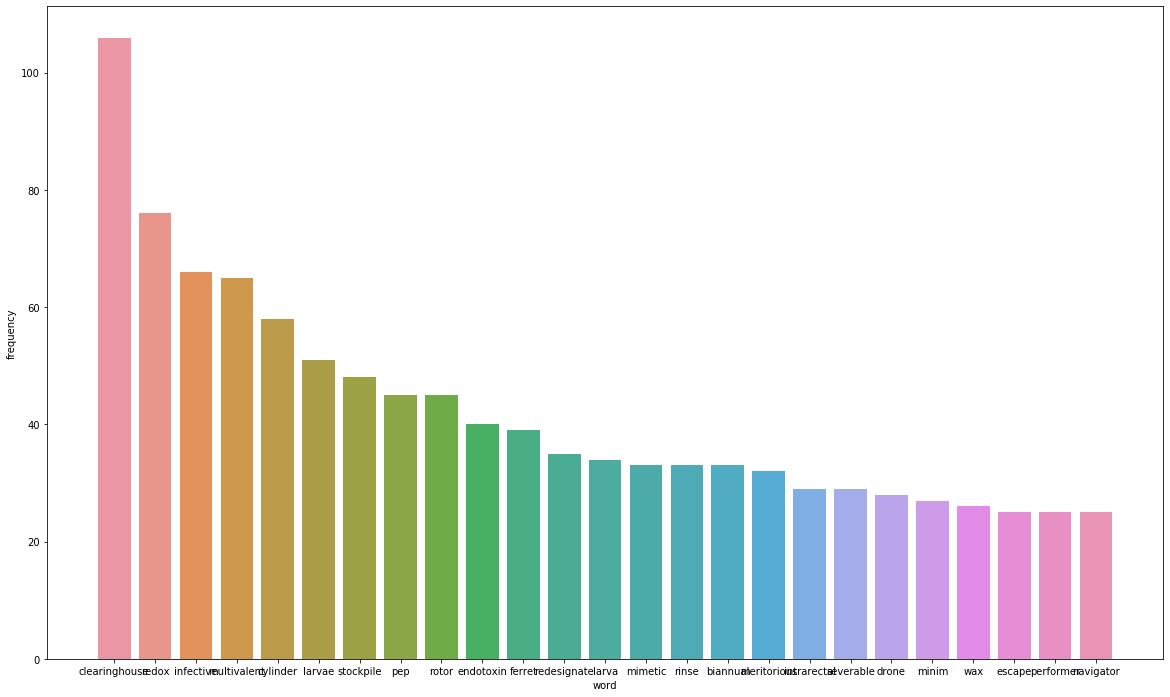

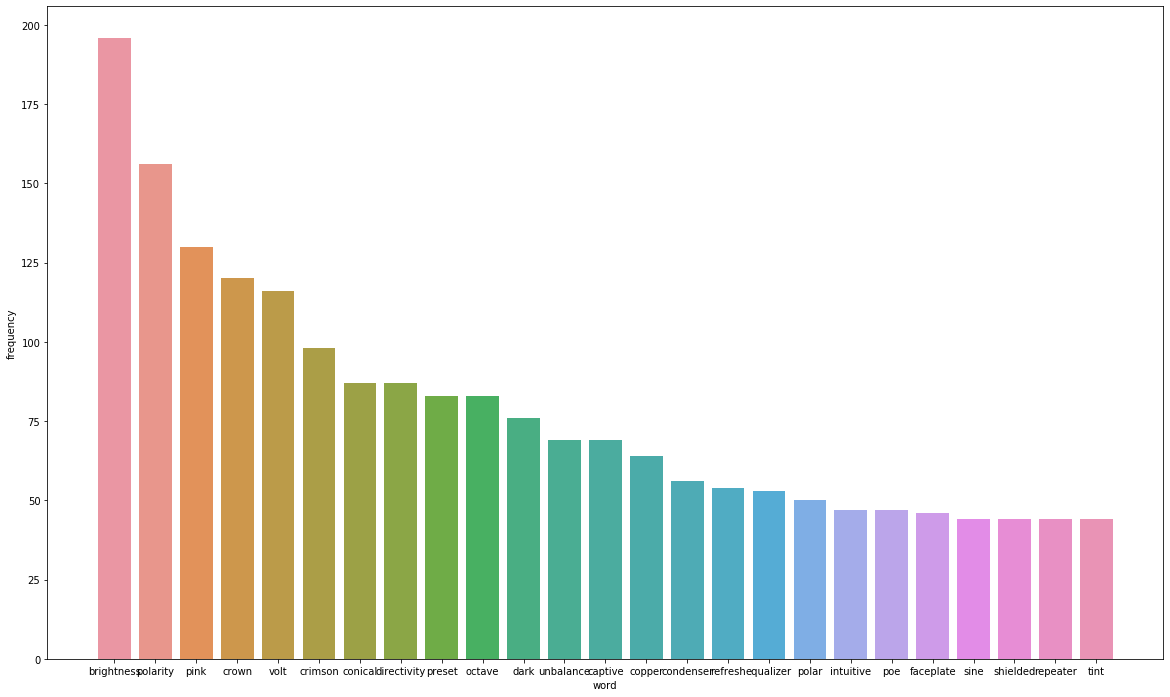

In [634]:
%%time

def get_top_words_list(df):
    word_list = []

    df['lower_text'].map(lambda row: word_list.extend(row.split()))

    counter_df = pd.DataFrame.from_dict(Counter(word_list), orient='index').reset_index()

    counter_df.columns = ['word', 'frequency']

    return counter_df.sort_values(by = 'frequency', ascending = False)

def plot_top_words(df):
    top_counter_df_no = get_top_words_list(df[df.is_fitara == 0])
    top_counter_df_yes = get_top_words_list(df[df.is_fitara == 1])
    
    exclusive_no = set(top_counter_df_no['word'].values) - set(top_counter_df_yes['word'].values)
    exclusive_yes = set(top_counter_df_yes['word'].values) - set(top_counter_df_no['word'].values)
    
    english_words = set(nltk.corpus.words.words())
    
    # Keep Only common words 
    exclusive_no = [word for word in exclusive_no if word in english_words]
    exclusive_yes = [word for word in exclusive_yes if word in english_words]
    
    exclusive_no_df = top_counter_df_no[top_counter_df_no['word'].isin(exclusive_no)]
    exclusive_yes_df = top_counter_df_yes[top_counter_df_yes['word'].isin(exclusive_yes)]
    
    plt.figure(figsize=(20,12))
    sns.barplot(x = 'word', y = 'frequency', data = exclusive_no_df.head(25))
    plt.plot()
    plt.figure(figsize=(20,12))
    sns.barplot(x = 'word', y = 'frequency', data = exclusive_yes_df.head(25))
    plt.plot()
    
    #return exclusive_no_df, exclusive_yes_df
    #return top_counter_df_no, top_counter_df_yes, exclusive_no, exclusive_no, exclusive_no_df, exclusive_yes_df

plot_top_words(train_df)

### Handle Categorical Variables

In [656]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['document_type'])], axis=1)
train_df.drop(['document_type'], axis=1, inplace=True)

### Ablation

In [635]:
if ablation:
    train_df_no = train_df[train_df.is_fitara == 0]
    train_df_yes = train_df[train_df.is_fitara == 1]

    # Get 15% of total Records for Ablation
    train_df_no_ablation = train_df_no.loc[0:int(len(train_df_no) * ablation_ratio)]
    train_df_yes_ablation = train_df_yes.loc[0:int(len(train_df_yes) * ablation_ratio)]
    
    # Shuffle rows and reset index
    train_df = pd.concat([train_df_yes_ablation, train_df_no_ablation]).sample(frac=1).reset_index(drop=True)

### Train Test Split

In [660]:
X = train_df.drop(['is_fitara'], axis=1)
y = train_df['is_fitara']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Tokenize the Strings

In [661]:
text_col = 'lower_text'

if use_tokenizer:
    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(X_train[text_col]))
    X_train[text_col] = tokenizer.texts_to_sequences(X_train[text_col])
    X_test[text_col] = tokenizer.texts_to_sequences(X_test[text_col])

### Pad the sentences 

In [662]:
# Find Max Length
train_max_len = np.percentile(X_train[text_col].apply(len), pad_percentile)
test_max_len = np.percentile(X_test[text_col].apply(len), pad_percentile)

max_len = int(test_max_len if train_max_len < test_max_len else train_max_len)

# Pad the Sentences
X_train_temp = pd.DataFrame(pad_sequences(X_train[text_col], maxlen=max_len), index = X_train.index)
X_test_temp = pd.DataFrame(pad_sequences(X_test[text_col], maxlen=max_len), index = X_test.index)

# Remove Existing DF
X_train.drop([text_col], axis=1, inplace=True)
X_test.drop([text_col], axis=1, inplace=True)

# Create new DF
X_train = pd.concat([X_train_temp, X_train], axis = 1)
X_test = pd.concat([X_test_temp, X_test], axis = 1)

### Standard Scaler Transformation

In [663]:
scaler = StandardScaler()

cols = X_train.columns
#cols = ['total_length','capitals','caps_vs_length','num_words','num_unique_words','words_vs_unique']

train_features = X_train[cols].values
test_features = X_test[cols].values

scaler.fit(train_features)

train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

X_train[cols] = pd.DataFrame(train_features, columns = cols, index = X_train.index)
X_test[cols] = pd.DataFrame(test_features, columns = cols, index = X_test.index)

In [664]:
X_train.to_csv(os.path.join(ROOT_DIR, r'train', r'train_pad.csv'), index = False)
X_test.to_csv(os.path.join(ROOT_DIR, r'test', r'test_pad.csv'), index = False)

In [783]:
X_train = pd.read_csv(os.path.join(ROOT_DIR, r'train', r'train_pad.csv'))
X_test = pd.read_csv(os.path.join(ROOT_DIR, r'test', r'test_pad.csv'))

### Principle Component Analysis

In [784]:
pca = PCA(n_components = pca_components)

cols = X_train.iloc[:, 0:max_len].columns

pca.fit(X_train[cols])

X_train_pca = pd.DataFrame(pca.transform(X_train[cols]))
X_test_pca = pd.DataFrame(pca.transform(X_test[cols]))

print(f"Variance Explained by Model is {pca.explained_variance_ratio_.cumsum()[-1]}")

Variance Explained by Model is 0.9031489822981176


In [785]:
# Remove Old Columns
X_train.drop(cols, axis=1, inplace=True)
X_test.drop(cols, axis=1, inplace=True)

# Append PCA Columns
X_train = pd.concat([X_train, X_train_pca], axis=1)
X_test = pd.concat([X_test, X_test_pca], axis=1)

### Model Building
First Try fitting a Simple Neural Network

In [787]:
# fix random seed for reproducibility
np.random.seed(576)

# create model
model = Sequential()
model.add(Dense(35, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(18, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

#model = Sequential()
#model.add(Dense(35, input_dim=X_train.shape[1], activation='sigmoid'))
#model.add(Dropout(0.25))
#model.add(Dense(18, kernel_initializer='normal', activation='sigmoid'))
#model.add(Dense(2, kernel_initializer='normal', activation='sigmoid'))
# Compile model
#sgd = SGD(lr=0.01, momentum=0.8, decay=0.0, nesterov=False)
#model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# train model
history = model.fit(X_train, to_categorical(y_train, 2), epochs=300, batch_size=10, verbose=2)#, class_weight={1:0.96, 0:0.04})

num_train = metrics.log_loss(y_train.values, model.predict(X_train))
num_test = metrics.log_loss(y_test.values, model.predict(X_test))

print(f"Log Loss on Train is {num_train} and exponential is {math.exp(-num_train)}.\
      \nLog Loss on Test is {num_test} and exponential is {math.exp(-num_test)}.")

Epoch 1/300
 - 2s - loss: 0.7476 - acc: 0.4958
Epoch 2/300
 - 0s - loss: 0.5782 - acc: 0.7249
Epoch 3/300
 - 0s - loss: 0.5661 - acc: 0.7221
Epoch 4/300
 - 0s - loss: 0.5474 - acc: 0.7235
Epoch 5/300
 - 0s - loss: 0.5322 - acc: 0.7332
Epoch 6/300
 - 0s - loss: 0.5190 - acc: 0.7542
Epoch 7/300
 - 0s - loss: 0.5052 - acc: 0.7654
Epoch 8/300
 - 0s - loss: 0.4771 - acc: 0.7975
Epoch 9/300
 - 0s - loss: 0.4666 - acc: 0.7863
Epoch 10/300
 - 0s - loss: 0.4508 - acc: 0.8156
Epoch 11/300
 - 0s - loss: 0.4220 - acc: 0.8212
Epoch 12/300
 - 0s - loss: 0.4168 - acc: 0.8212
Epoch 13/300
 - 0s - loss: 0.3921 - acc: 0.8408
Epoch 14/300
 - 0s - loss: 0.3868 - acc: 0.8380
Epoch 15/300
 - 0s - loss: 0.3876 - acc: 0.8296
Epoch 16/300
 - 0s - loss: 0.3743 - acc: 0.8450
Epoch 17/300
 - 0s - loss: 0.3696 - acc: 0.8506
Epoch 18/300
 - 0s - loss: 0.3605 - acc: 0.8478
Epoch 19/300
 - 0s - loss: 0.3486 - acc: 0.8589
Epoch 20/300
 - 0s - loss: 0.3579 - acc: 0.8394
Epoch 21/300
 - 0s - loss: 0.3387 - acc: 0.8617
E

Epoch 171/300
 - 0s - loss: 0.0738 - acc: 0.9777
Epoch 172/300
 - 0s - loss: 0.0786 - acc: 0.9763
Epoch 173/300
 - 0s - loss: 0.0865 - acc: 0.9693
Epoch 174/300
 - 0s - loss: 0.0847 - acc: 0.9721
Epoch 175/300
 - 0s - loss: 0.0753 - acc: 0.9707
Epoch 176/300
 - 0s - loss: 0.0788 - acc: 0.9804
Epoch 177/300
 - 0s - loss: 0.0648 - acc: 0.9832
Epoch 178/300
 - 0s - loss: 0.0910 - acc: 0.9707
Epoch 179/300
 - 0s - loss: 0.0803 - acc: 0.9735
Epoch 180/300
 - 0s - loss: 0.0753 - acc: 0.9721
Epoch 181/300
 - 0s - loss: 0.0965 - acc: 0.9693
Epoch 182/300
 - 0s - loss: 0.0857 - acc: 0.9735
Epoch 183/300
 - 0s - loss: 0.0575 - acc: 0.9874
Epoch 184/300
 - 0s - loss: 0.0747 - acc: 0.9735
Epoch 185/300
 - 0s - loss: 0.0707 - acc: 0.9791
Epoch 186/300
 - 0s - loss: 0.0738 - acc: 0.9749
Epoch 187/300
 - 0s - loss: 0.0617 - acc: 0.9735
Epoch 188/300
 - 0s - loss: 0.0688 - acc: 0.9749
Epoch 189/300
 - 0s - loss: 0.0696 - acc: 0.9735
Epoch 190/300
 - 0s - loss: 0.0940 - acc: 0.9651
Epoch 191/300
 - 0s 

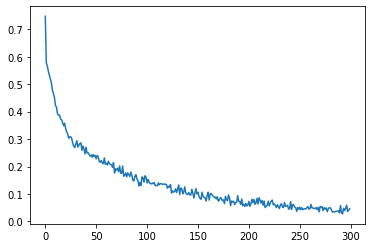

In [788]:
# plot metrics
plt.plot(history.history['loss'])
plt.show()

In [789]:
num_train = metrics.log_loss(y_train.values, model.predict(X_train))
num_test = metrics.log_loss(y_test.values, model.predict(X_test))

print(f"Log Loss on Train is {num_train} and exponential is {math.exp(-num_train)}.\
      \nLog Loss on Test is {num_test} and exponential is {math.exp(-num_test)}.")

Log Loss on Train is 0.009489450201795263 and exponential is 0.9905554325477011.      
Log Loss on Test is 1.907528518821272 and exponential is 0.1484468171104126.


Let's check cross validation score for different algorithms on training Data

LR: 0.671909 ( +- 0.053170) | Accuracy : 13.584479
NB: 0.666119 ( +- 0.053826) | Accuracy : 12.572803
LDA: 0.664789 ( +- 0.060317) | Accuracy : 11.994839
KNN: 0.681514 ( +- 0.070819) | Accuracy : 12.428356
TREE: 0.649315 ( +- 0.038834) | Accuracy : 13.873497
CART: 0.722027 ( +- 0.034125) | Accuracy : 10.260697
NB: 0.670344 ( +- 0.040807) | Accuracy : 10.694208
SVM: 0.737383 ( +- 0.040574) | Accuracy : 10.260708


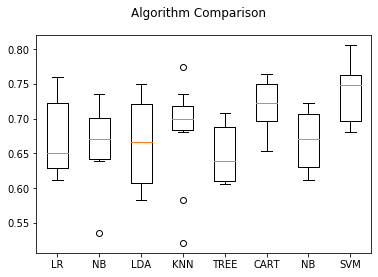

In [828]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict

estimators = []

estimators.append(('LR', LogisticRegression()))
estimators.append(('NB', BernoulliNB(alpha=.01)))
estimators.append(('LDA', LinearDiscriminantAnalysis()))
estimators.append(('KNN', KNeighborsClassifier()))
estimators.append(('TREE', DecisionTreeClassifier()))
estimators.append(('CART', RandomForestClassifier(n_estimators=100)))
estimators.append(('NB', GaussianNB()))
estimators.append(('SVM', SVC(probability=True)))

# evaluate each model in turn
results = []
names = []
for name, model in estimators:
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    #cv_results = model_selection.cross_val_predict(model, X_train, y_train, cv=kfold)
    
    results.append(cv_results)
    names.append(name)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    log_loss = metrics.log_loss(y_pred, y_test)
    
    msg = "%s: %f ( +- %f) | Accuracy : %f" % (name, cv_results.mean(), cv_results.std(), log_loss)
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [823]:
math.exp(-12.89)

2.5231561490262545e-06

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.006s
test time:  0.001s
accuracy:   11.417
confusion matrix:
[[141  23]
 [ 56  19]]

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=50, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=F

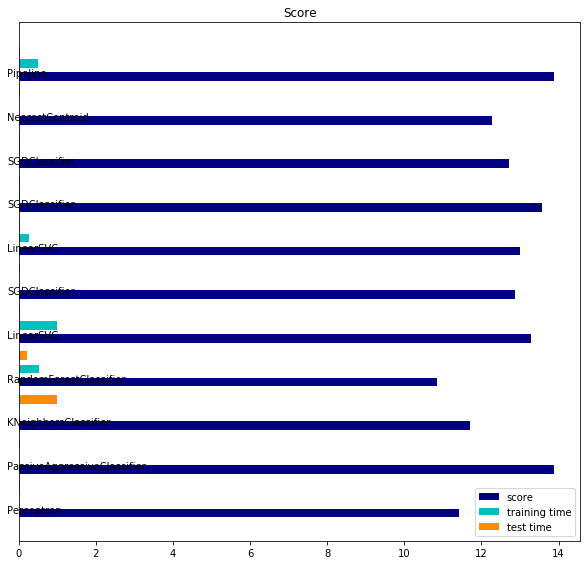

In [833]:



def trim(s):
    # Trim string to fit on terminal (assuming 80-column display)
    return s if len(s) <= 80 else s[:77] + "..."

# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    
    t0 = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time.time()
    pred = clf.predict(X_test)
    test_time = time.time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.log_loss(y_test, pred)
    print("accuracy:   %0.3f" % score)
    
    #if hasattr(clf, 'coef_'):
    #    print("dimensionality: %d" % clf.coef_.shape[1])
    #    print("density: %f" % density(clf.coef_))

        #if opts.print_top10 and feature_names is not None:
    #    print("top 10 keywords per class:")
    #    for i, label in enumerate(target_names):
    #        top10 = np.argsort(clf.coef_[i])[-10:]
    #        print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
    #    print()
    
    #if opts.print_report:
    #print("classification report:")
    #print(metrics.classification_report(y_test, pred))

    #if opts.print_cm:
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

results = []
for clf, name in (
        #(RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50, tol=1e-3), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50, tol=1e-3),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
#results.append(benchmark(MultinomialNB(alpha=.01)))
#results.append(benchmark(BernoulliNB(alpha=.01)))
#results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()
